# Learning Objectives

Build LLM applications for retrieval-augmented generation tasks.


# Setup

In [ ]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                pypdf==4.0.1 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import tiktoken

import pandas as pd

from openai import OpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

In [ ]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [ ]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

In [ ]:
model_name = 'mlabonne/NeuralHermes-2.5-Mistral-7B'

# Retrieval-Augmented Generation (RAG)

An important application of LLMs is enabling users to query unstructured data in natural language. This is finding a lot of traction in industries where the data is naturally unstructured in nature (e.g., finance, healthcare). The figure below shows how the finance sector is utilizing LLMs to query and summarize documents.

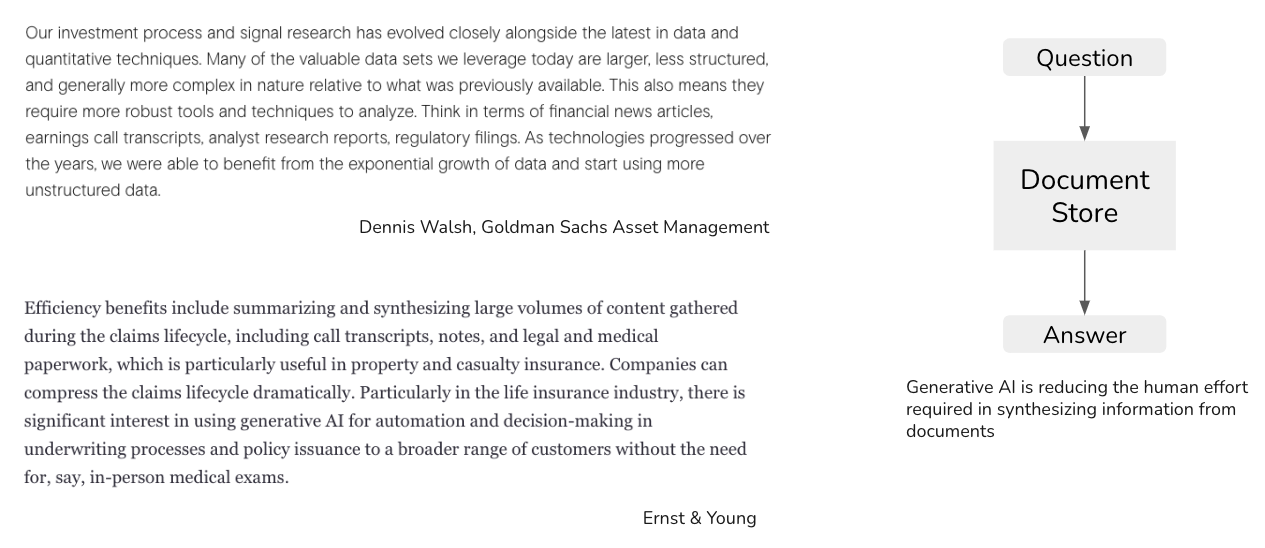

Document-based Q&A is achieved using Retrieval-Augmented Generation (RAG). RAG is a technique that combines the capabilities of pre-trained large language models (LLMs) with external data sources to generate more accurate and informative text. The key ideas are:

1. Bridging the gap between generative models and external knowledge: RAG integrates LLMs, which excel at generating fluent text, with retrieval models that can access and incorporate relevant information from external knowledge bases or databases.

2. Improving contextual understanding and content generation: By accessing external information, RAG models can generate text that is not only fluent but also grounded in real-world knowledge, leading to more accurate and contextually relevant responses. This is particularly useful for tasks like question-answering, summarization, and dialogue systems.

3. Reducing bias and misinformation: RAG can help verify generated content against external sources, incorporating diverse perspectives and producing more balanced and factually accurate outputs. This helps address issues of bias and misinformation that can arise in standalone LLMs.

4. Flexibility and scalability: RAG architectures are designed to be flexible and adaptable, allowing them to leverage domain-specific knowledge bases and scale effectively to handle large-scale information sources.

5. Continuous learning and improvement: RAG systems can be designed to continuously learn and improve over time by incorporating feedback mechanisms and iterative refinement processes. This contributes to the long-term effectiveness and reliability of RAG-powered applications.

In summary, RAG combines the strengths of generative language models and retrieval models to produce text that is more accurate, contextually relevant, and grounded in external knowledge, addressing key limitations of standalone LLMs.

The figure below summarizes the key idea of RAG.

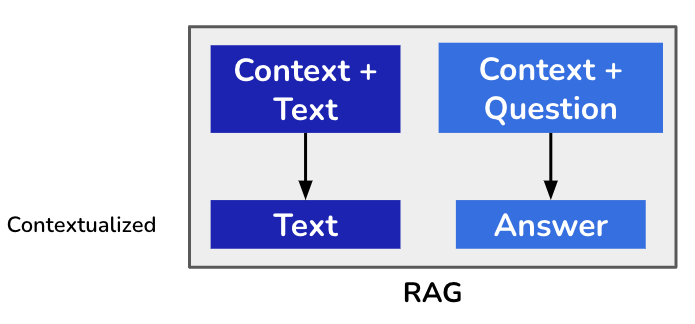

# RAG Building Blocks

## A workflow for RAG

The figure below depicts the key stages involved in designing a RAG solution using LLMs. Let us look at each stage in detail.

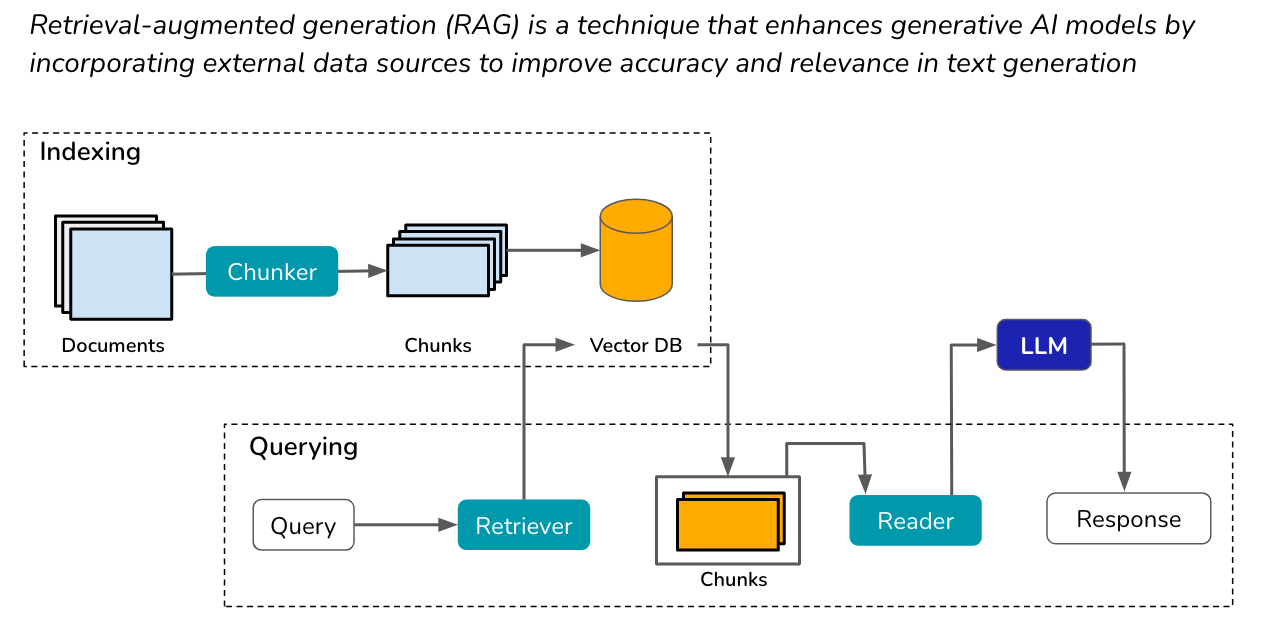

**Indexing**

In the first step, we ingest the different sources of data into a document database. At this stage, the focus is on assembling all the data (irrespective of format, e.g., text, pdf) relevant to the use case and data exists in the raw unmodified form. However, given context window limitations of LLMs, we cannot stuff all the documents in the database as context. Even if we did have an infinite context window, the LLM would find it difficult to provide a coherent answer while sifting through the noise for the signal. To avoid this situation, we will need to carefully select documents that relate to the user input so the LLM can be tasked to answer based only on the context.

A key method to aid retrieval of relevant documents is to convert the ingested raw data into a vector representation. This way, we can compare the query (converted into a vector) with the document vectors and choose only those documents that are similar to the query. This process of creating a vector representation from input text is called embedding and is achieved using embedding models (for e.g., SentenceTransformer). Once embeddings are created they can be stored for efficient retrieval in specialized vector data stores such as Pinecone or ChromaDB (we use ChromaDB in this notebook).


While embeddings solve for retrieval of appropriate context given a query, a more efficient application of vectorization is to transform raw data into smaller chunks before feeding it to an embedding model. There are two important reasons why this is needed:

- Embedding models are themselves Transformer models and hence have input length constraints. Any text that is longer than the maximum input length allowed by the embedding model is usually truncated.
- Slicing the data into chunks facilitates fine-grained control on the specific information that can be injected as context. This helps the model focus only on the information most relevant to the query.

**Retrieval**

In the second step, a prompt is dynamically assembled when a user input is received. This user input is converted to a vector representation using the same model that was used for the context chunks. Then a similary search is executed against the vectorized chunks in the vector database. Top-$k$ chunks from the search results in this step are then stuffed into the prompt as the context and the LLM is instructed to answer the user query using only the context.

To facilitate indexing and retrieval, abstractions such a chunkers, retrievers and readers are used that interface with the document database, vector database and the LLM respectively. Popular packages that implement these abstractions are `langchain` and `llamaindex`.

Now that we have an overview of the process, let us take a deeper look at each of these steps.

## Step 1: Creating a Vector Database (Indexing)

We create a vector database by chunking the input document and then associating each chunk with a vector using an embedding model. The overall process is described in the figure below.

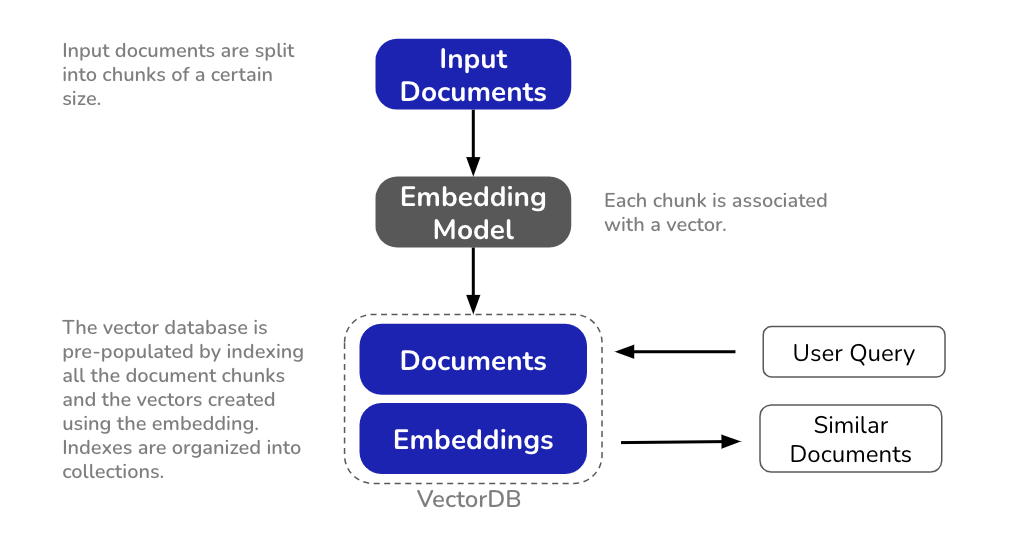

As the above figure indicates, there are two important components of vector database creation that merit a deeper look - choice of embedding model and chunking.

### Choosing an embedding model

Let us first recap what embeddings are:

- Embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
- They capture semantic properties of words and relations with other words.


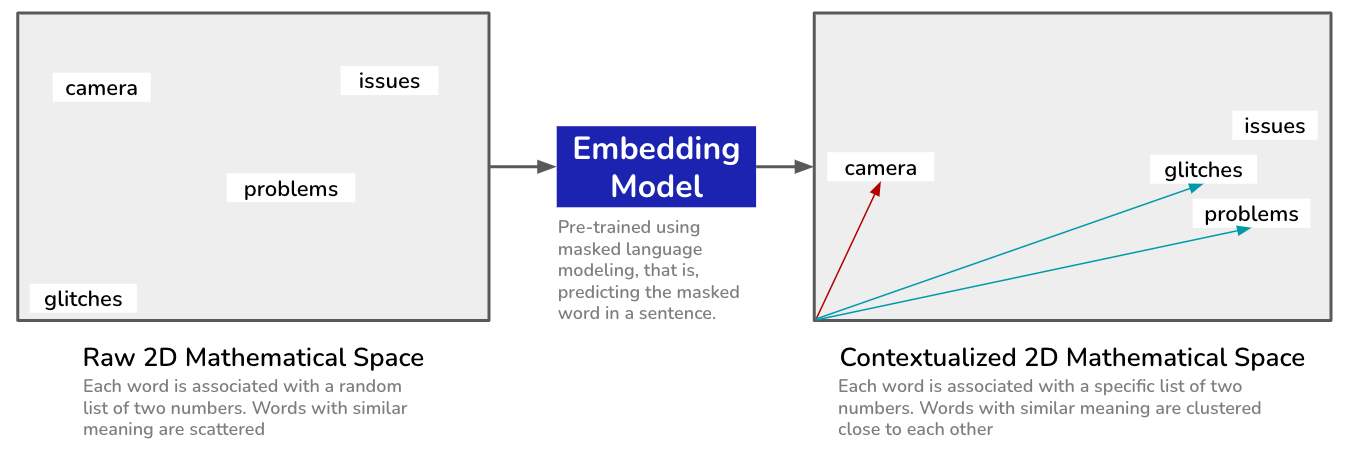

Similar to word embedding models, sentence embedding models represent the meaning of whole sentences. They are derived by averaging word embeddings or using specialized embedding models.

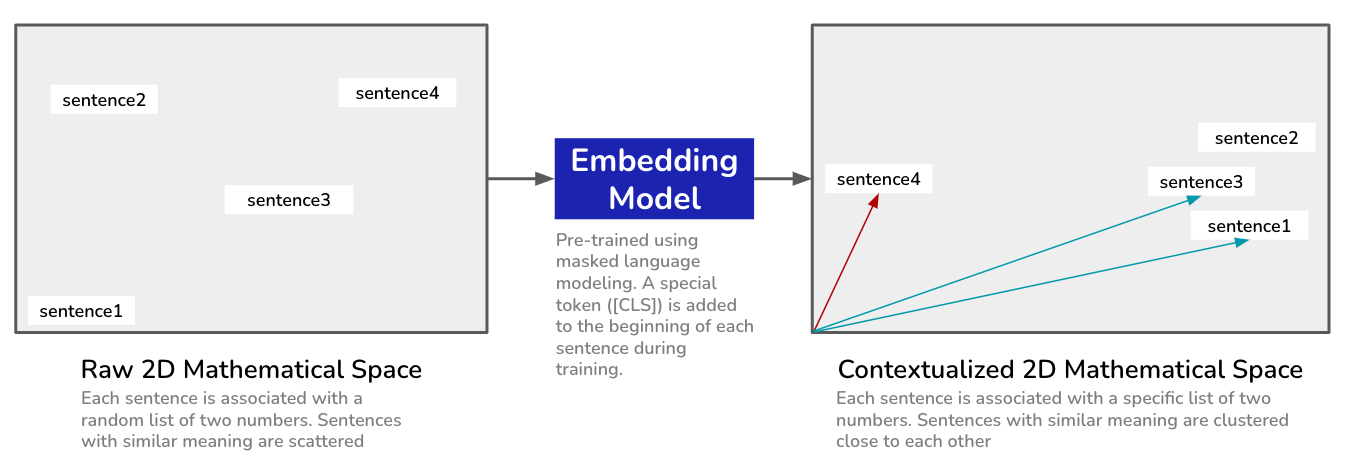

Good embedding models encode text into vector representations that act as good features for the downstream LLM tasks (for e.g., in this case, retrieval). However, there are many embedding models to choose from (both free and paid) and the choice is not often not straight forward. Moreover, there is no evidence that free/open-source embedding models (for e.g., models hosted on HuggingFace) are less effective compared to paid models (for e.g., from Open AI).

A good method to choose an embedding model, is to use the [embedding leaderboard](https://huggingface.co/spaces/mteb/leaderboard) and select an open source model that is performant for the use case at hand.

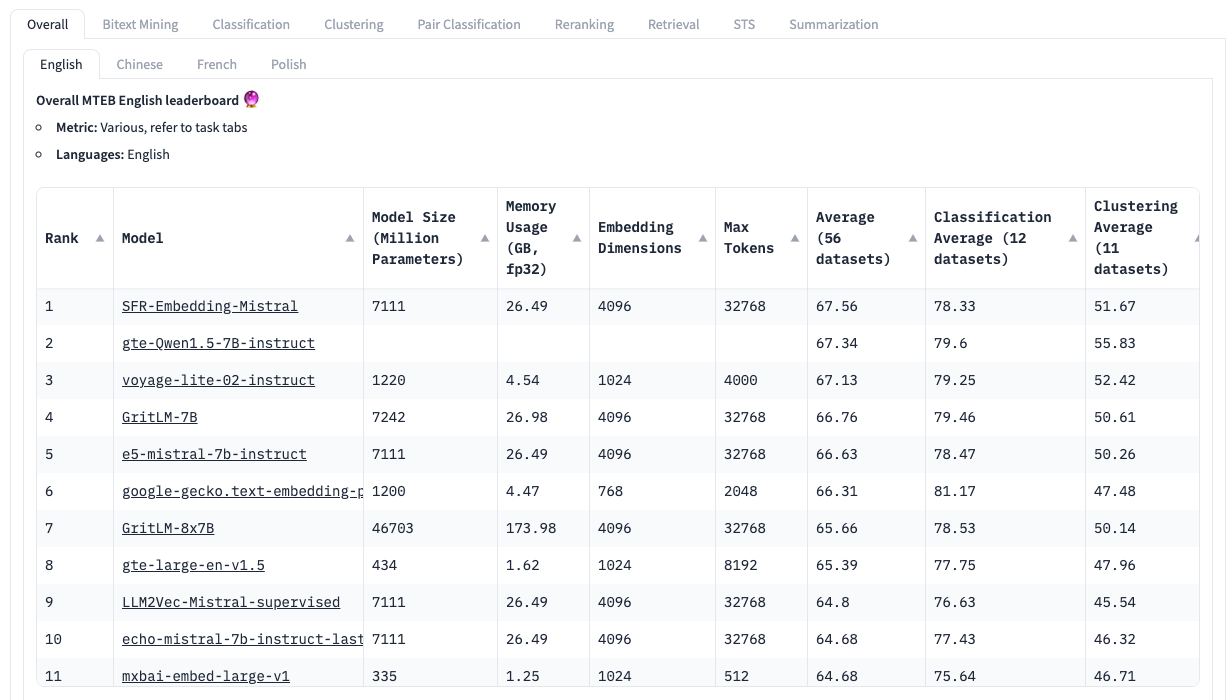

A good general purpose embedding model is [`gte-large`](https://huggingface.co/thenlper/gte-large).

### Chunking documents

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (512 tokens for `gte-large`). This roughly corresponds to about 400 words or about 1 page of text. With this limitation in mind, we will transform the pdf file into chunks of text that are no more than 512 chunks long. An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below).


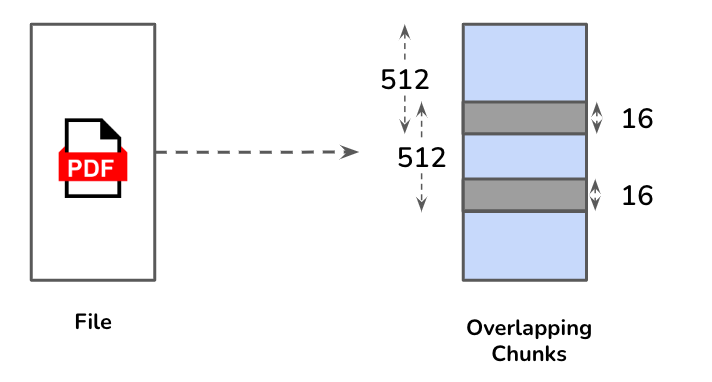

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

### Creating a persistent vector database

With an embedding model and chunking strategy in place, we can set up an information processing pipeline, where each document is parsed into a Python runtime, chunked and passed to the embedding model. The document chunk and embedding is then stored as an entry in the vector database.

Note that the vector databases themselves are full fledged databases. They support the entire gamut of Create, Read, Update and Delete (CRUD) operations. In this notebook, we will use `langchain` abstractions to chunk and create a persistent database. Refer to the [Chroma DB documentation](https://docs.trychroma.com/api-reference) for an overview on CRUD operations.

## Step 2: Querying the Vector Database

Once the vector database is set up, embedding generated from the query text is compared with all the document embeddings in the vector database. The most similar documents are then retrieved and presented along with the original query in the prompt.

Finally, in the prompt, we instruct the LLM to focus only on the context to answer the user query. The key idea here is that both the query and the context are both dynamically injected into the prompt.

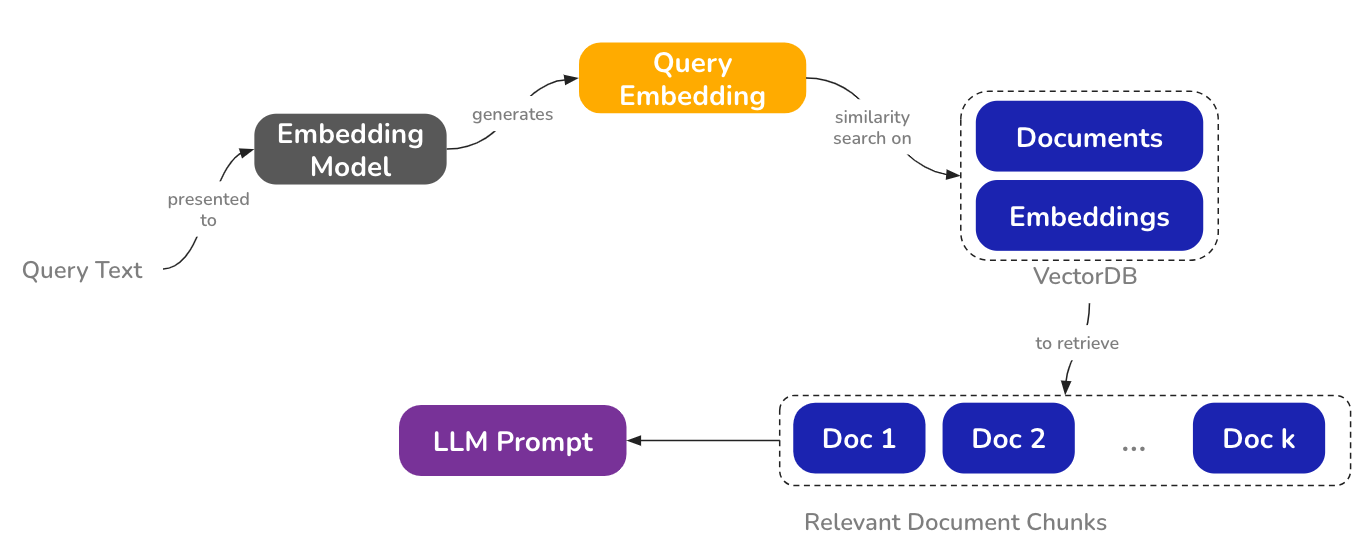

## Evaluation

Since RAG is a special case of text-to-text generation, evaluation is no different from what we saw before. We either use human baselines or use LLM-as-a-judge to evaluate RAG workflows.

However, since RAG systems have two compponents (indexing and retrieval), they are usually judged on [two important parameters](https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics):
- Groundedness/Faithfulness: How much of the answer is drawn from the context?
- Relevance: How relevant is the answer to the query, given the context?

These two metrics check the quality two components of the RAG system - retrieval and generation. To evaluate these components individually, it is common to use LLM-as-a-judge method to check the quality of the RAG system. We write two prompts corresponding to each of these metrics and using the user input, context and answer, evaluate the performance of the RAG system.

Just like in the case of evaluation of classification and summarization, it is critical to create a pool of gold examples that reflect the user intent.

# Business Use Case

Let us now implement the RAG workflow to enable question-answering on a selection of Tesla 10-k statements for the period 2019 - 2023 (5 years). This implementation will enable users to query information contained within these 10-k statements and the system will retrieve appropriate context and answer user queries.

# Impementing RAG

## Assemble Vector Database (One-time Setup)

Note: This portion needs a T4 GPU. Once the database is created, we store the database in Google Drive for easy access during querying without relying on GPUs.

### Download Raw Data

In [ ]:
!unzip tesla-annual-reports.zip

Archive:  tesla-annual-reports.zip
   creating: tesla-annual-reports/
  inflating: tesla-annual-reports/tsla-20221231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20221231-gen.pdf  
  inflating: tesla-annual-reports/tsla-20231231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20231231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10ka_20211231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10ka_20211231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20201231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20201231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20191231-gen_0.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20191231-gen_0.pdf  


### Chunking

In [ ]:
pdf_folder_location = "tesla-annual-reports"

In [ ]:
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)

Notice how we now have a selection of documents in multiple files within a folder. We point the `PyPDFDirectorLoader` to this folder and allow it to load and chunk each file within the directory (i.e., loop over each file in the directory, chunk the file and store chunks in a list).

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [ ]:
tesla_10k_chunks_ada = pdf_loader.load_and_split(text_splitter)

(Note: Expect that the above cell will take time to execute).

In [ ]:
len(tesla_10k_chunks_ada)

3342

### Database Creation

In [ ]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
vectorstore = Chroma.from_documents(
    tesla_10k_chunks_ada,
    embedding_model,
    collection_name=tesla_10k_collection,
    persist_directory='./tesla_db'
)

In [ ]:
vectorstore.persist()

In [ ]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory='./tesla_db',
    embedding_function=embedding_model
)

In [ ]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

Upload the current DB state to Google Drive, so we can avoid using GPU during querying.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r tesla_db /content/drive/MyDrive/

(Since the vector database state is saved, we no longer need the GPU).

## Load Retriever with Vector DB from Google Drive

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Since we persisted the database to a Google Drive location, we can download the database to the instance using its unique id like so:

In [ ]:
persisted_vectordb_location = '/content/drive/MyDrive/tesla_db'

In practise, the database is maintained as a separate entity and CRUD operations are managed just as one would for normal databases (e.g., relational databases).

In [ ]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [ ]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

In [ ]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

## RAG Q&A

### Prompt Design

In [ ]:
qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user questions.
This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Please answer only using the context provided in the input. Do not mention anything about the context in your final answer.

If the answer is not found in the context, respond "I don't know".
"""

In [ ]:
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### Retrieving relevant documents

In [ ]:
user_input = "What was the annual revenue of the company in 2022?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)

In [ ]:
len(relevant_document_chunks)

5

In [ ]:
for document in relevant_document_chunks:
    print(document.page_content.replace("\t", " "))
    break

systems.
In 2020, we recognized total revenues of $31.54 billion, representing an increase of $6.96 billion compared to the prior year. We continue to ramp
production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue
growth.
In 2020, our net income attributable to common stockholders was $721 million, representing a favorable change of $1.58 billion compared to the prior
year. In 2020, our operating margin was 6.3%, representing a favorable change of 6.6% compared to the prior year. We continue to focus on operational
efficiencies, while we have seen an acceleration of non-cash stock-based compensation expense due to a rapid increase in our market capitalization and updates
to our business outlook.
We ended 2020 with $19.38 billion in cash and cash equivalents, representing an increase of $13.12 billion from the end of 2019. Our cash flows from
operating activities during 2020 was $5.94 billion

### Composing the response

In [ ]:
user_input = "What was the annual revenue of the company in 2022?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The annual revenue of the company in 2022 was $81,462 million.


## Evaluation

Let us now use the LLM-as-a-judge method to check the quality of the RAG system on two parameters - retrieval and generation. We illustrate this evaluation based on the answeres generated to the question from the previous section.

In [ ]:
rater_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [ ]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [ ]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
"""

In [ ]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [ ]:
user_input = "What was the annual revenue of the company in 2022?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [ ]:
prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

response = client.chat.completions.create(
    model=model_name,
    messages=prompt,
    temperature=0
)

answer = response.choices[0].message.content.strip()

In [ ]:
print(answer)

The annual revenue of the company in 2022 was $81,462 million.


In [ ]:
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [ ]:
response = client.chat.completions.create(
    model=rater_model,
    messages=groundedness_prompt,
    temperature=0
)

print(response.choices[0].message.content)

 Steps to evaluate the answer:
1. Identify the question that the AI was asked.
2. Identify the context that the AI was given to generate the answer.
3. Analyze the AI's answer to see if it is derived only from the information presented in the context.

Step-by-step explanation:
1. The AI was asked "What was the annual revenue of the company in 2022?"
2. The context provided to the AI includes financial information for the company, including revenues for various years and segments.
3. The AI's answer is "The annual revenue of the company in 2022 was $81,462 million." This information is directly provided in the context under the table "Revenues" for the year ended December 31, 2022.

Extent to which the metric is followed: The metric is followed completely. The AI's answer is directly derived from the information presented in the context.

Answer rating: 5 (The metric is followed completely)


In [ ]:
relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [ ]:
response = client.chat.completions.create(
    model=rater_model,
    messages=relevance_prompt,
    temperature=0
)

print(response.choices[0].message.content)

 Steps to evaluate the context:
1. Identify the annual revenue of the company in 2022 from the context.
2. Check if the identified revenue is provided in the same units as the question (i.e., millions of dollars).

Explanation:

1. From the context, we can find the following information about the company's revenues:
	* 2020 revenues: $31,536 million
	* 2021 revenues: $53,823 million
	* 2022 revenues: $81,462 million
2. The units are consistent with the question, as all figures are in millions of dollars.

Evaluation:
The metric is followed completely.

Rating:
5 (The metric is followed completely)
